# <center> Обучение с учителем. Классификация
## <center> Логистическая регрессия в sklearn

Мы будем работать со знакомым вам по модулю «Очистка данных» наборе данных о диабете, первоначально полученном в Национальном институте диабета, болезней органов пищеварения и почек.

Наша цель будет состоять в том, чтобы диагностически предсказать, есть ли у пациента диабет. На выбор экземпляров из более крупной базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года из индейского племени Пима.

В модуле по очистке данных вы уже производили очистку этого набора данных:

* удалили дубликаты,
* удалили неинформативный признак Gender,
* обработали «скрытые» пропуски в данных,
* избавились от потенциальных выбросов.

Итак, импортируем библиотеки, необходимые нам для работы с данными:

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

Затем прочитаем нашу таблицу:

In [3]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


Напомним, какие признаки у нас есть:

* Pregnancies — количество беременностей;
* Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе;
* BloodPressure — диастолическое артериальное давление (мм рт. ст.);
* SkinThickness — толщина кожной складки трицепса (мм);
* BMI — индекс массы тела (вес в кг/рост в $м^2$);
* DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости);
* Age — возраст;
* Outcome — наличие диабета (0 — нет, 1 — да), целевой признак.

Размер таблицы:

In [4]:
print(diabetes_data.shape)

(757, 8)


Давайте посмотрим на матрицу корреляций и выберем наиболее коррелированные с целевым признаком факторы:

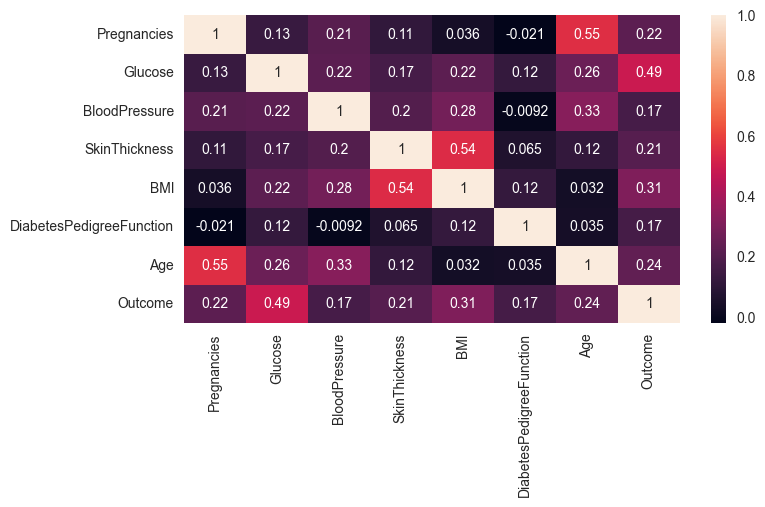

In [5]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(diabetes_data.corr(), annot=True);

Из строки Outcome видно, что наибольшей корреляцией с целевым признаком обладают факторы Glucose (уровень глюкозы) и BMI (индекс массы тела).

Построим диаграмму рассеяния, по оси абсцисс отложим фактор Glucose, а по оси ординат — BMI. Сделаем цветовую группировку по признаку наличия диабета:

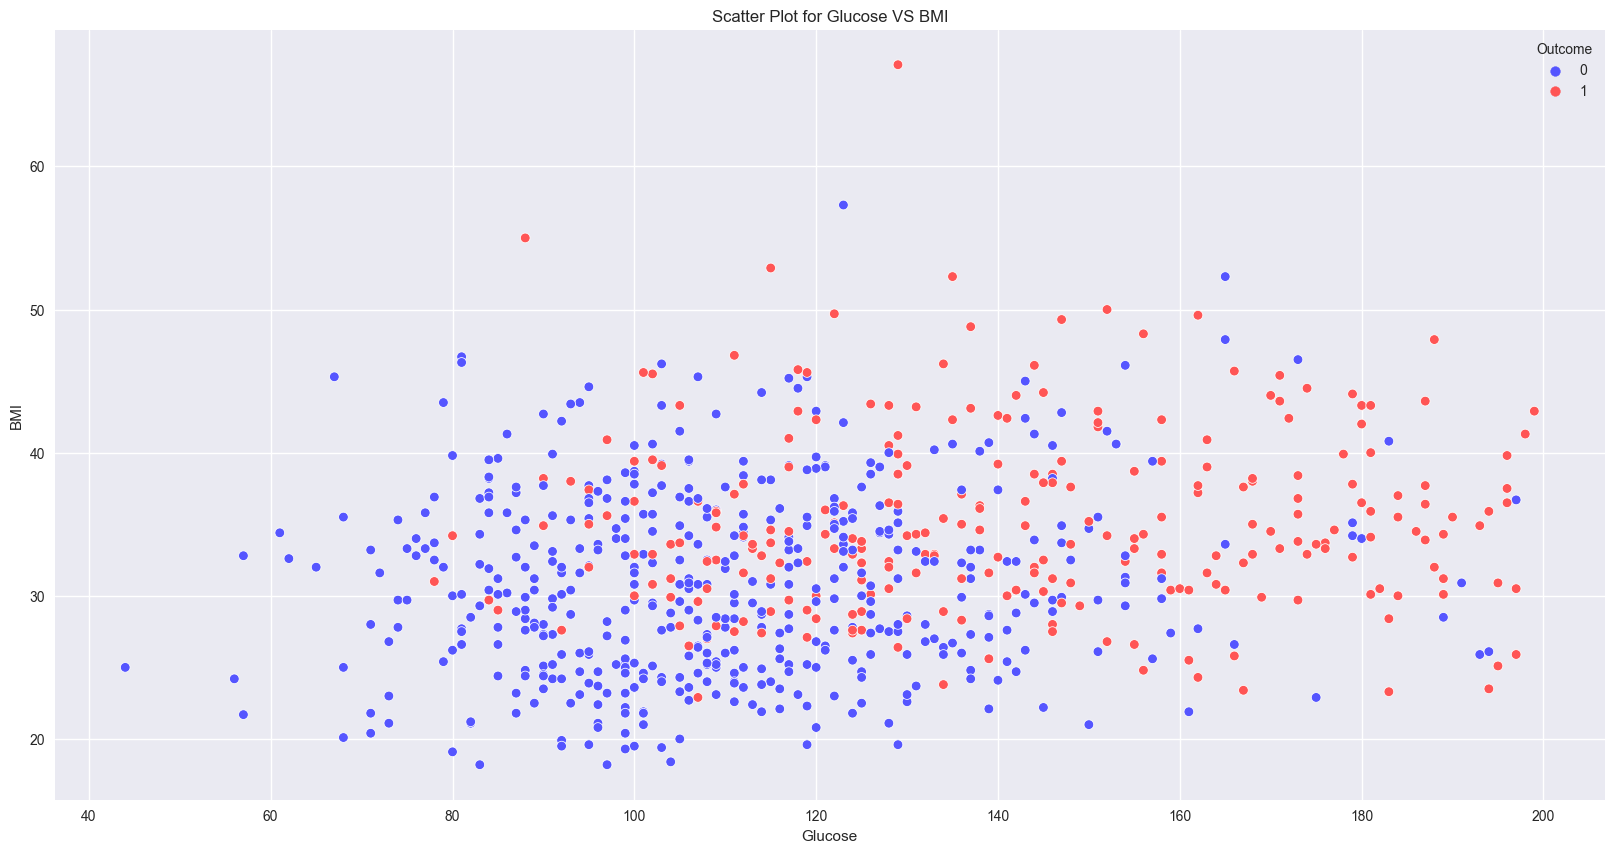

In [7]:
fig, ax = plt.subplots(figsize = (20, 10)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

Видно, что классы довольно сильно перемешаны, но красные точки, соответствующие пациентам с диабетом, преимущественно сгруппированы в правой части системы координат.

Давайте попробуем построить разделяющую плоскость с помощью логистической регрессии.

Для начала разделим выборку на матрицу наблюдений `X`, состоящую из двух признаков, и столбец с правильным ответами `y`:

In [8]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Логистическая регрессия — линейная модель, поэтому она находится в уже знакомом нам модуле `linear_model` из библиотеки `sklearn`.

In [9]:
from sklearn import linear_model #линейные модели

В модуле находится класс LogisticRegression, который реализует поиск коэффициентов разделяющей плоскости путём минимизации функции потерь logloss различными численными методами.



Основные параметры LogisticRegression:

* random_state — число, на основе которого происходит генерация случайных чисел.
* penalty — метод регуляризации. Возможные значения:
    * 'l1' — L1-регуляризация;
    * 'l2' — L2-регуляризация (используется по умолчанию);
    * 'elasticnet' — эластичная сетка (L1+L2);
    * None — отсутствие регуляризации.
* C — коэффициент обратный коэффициенту регуляризации, то есть равен . Чем больше C, тем меньше регуляризация. По умолчанию C=1, тогда α=1.
* solver — численный метод оптимизации функции потерь logloss, может быть:
    * 'sag' — стохастический градиентный спуск (нужна стандартизация/нормализация);
    * 'saga' — [модификация](https://arxiv.org/pdf/1407.0202.pdf) предыдущего, которая поддерживает работу с негладкими функциями (нужна стандартизация/нормализация);
    * 'newton-cg' — [метод Ньютона с модификацией сопряжённых градиентов](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#newton-conjugate-gradient-algorithm-method-newton-cg) (не нужна стандартизация/нормализация);
    * 'lbfgs' — [метод Бройдена — Флетчера — Гольдфарба — Шанно](https://ru.wikipedia.org/wiki/Алгоритм_Бройдена_—_Флетчера_—_Гольдфарба_—_Шанно) (не нужна стандартизация/нормализация; используется по умолчанию, так как из всех методов теоретически обеспечивает наилучшую сходимость);
    * 'liblinear' — [метод покоординатного спуска](http://www.machinelearning.ru/wiki/index.php?title=Метод_покоординатного_спуска) (не нужна стандартизация/нормализация).
* max_iter — максимальное количество итераций, выделенных на сходимость.

Обучим логистическую регрессию, сделав значением параметра `random_state`, например, число 42, чтобы гарантированно получить одинаковые результаты. Остальные параметры оставим по умолчанию.

Для обучения модели необходимо просто вызвать метод `fit()`, передав в него матрицу наблюдений `X` и вектор правильных ответов `y`.

Чтобы получить параметр $w_0$, нужно обратиться к атрибуту `intercept_`, а вектор параметров  $w_1$, $w_2$, ..., $w_m$  будет храниться в атрибуте `coef_` (так как в матрице `X` два фактора, то и коэффициента будет два):

In [10]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


> В отличие от линейной регрессии, коэффициенты логистической регрессии интерпретировать сложнее. Мы не будем этим заниматься.

Как нам сделать предсказание вероятности наличия диабета у пациента?

Мы должны подставить значения факторов в уравнение разделяющей плоскости, а затем подставить результат в функцию сигмоиды. Для этого есть метод `predict_proba()`.

Например, появился новый пациент с концентрацией глюкозы 180 мг/100мл и индексом массы тела в 51 $кг/м^2$. Мы хотим вычислить вероятность наличия/отсутствия диабета у данного пациента:

In [11]:
#Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод `predict_proba()` возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

Если мы хотим предсказать не вероятности, а сам класс (1 или 0), нам пригодится метод `predict()`. По умолчанию метод `predict()` относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [12]:
#Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


Предсказанный класс равен 1, значит, модель считает, что данный пациент болеет диабетом.

Теперь построим визуализацию нашей модели.

Чтобы красиво визуализировать вероятности в виде тепловой карты, мы подготовили специальную функцию — `plot_probabilities_2d()`.

Данная функция принимает три аргумента:

* `X` — матрица с наблюдениями,
* `y` — столбец с правильными ответами,
* `model` — модель, с помощью которой делается предсказание вероятностей.

> Мы не будем подробно останавливаться на работе данной функции — она нам нужна только для красивой визуализации, но если вы захотите разобраться, мы написали подробные комментарии к каждой строке кода.

In [13]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

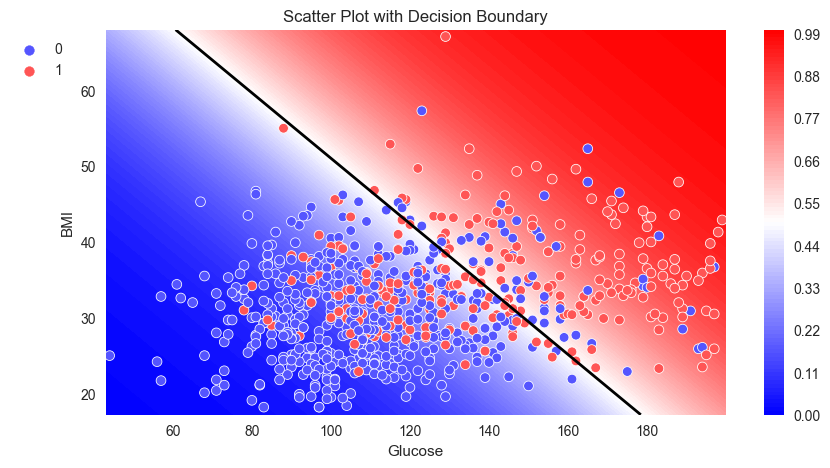

In [14]:
plot_probabilities_2d(X, y, log_reg_2d)

Мы видим разделяющую поверхность (обозначена чёрной линией). Она делит пространство на две части: красное соответствует точкам, которые будут отнесены моделью к классу 1, а синее соответствует точкам, которые будут отнесены моделью к классу 0.

Справа от графика есть цветовая панель, которая показывает значение вероятности того, что пациент болен диабетом (по мнению модели).

> Обратите внимание, что чем более точка удалена от разделяющей плоскости, тем с большей вероятностью модель относит её к тому или иному классу. На тепловой карте это прослеживается в интенсивности синего и красного цвета.


Из графика видно, что довольно много синих точек попали в красную зону и наоборот. Видимо, информации о двух факторах всё же маловато для того, чтобы хорошо провести классификацию.

Давайте будем использовать для построения модели всю предоставленную нам информацию — все факторы из набора данных. Для этого заново создадим матрицу наблюдений `X` и вектор ответов `y`:

In [15]:
#Создаем матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

Затем обучим модель логистической регрессии с помощью метода `fit()`.

Сделаем предсказание вероятности заболевания диабетом для каждого пациента и самих классов с помощью методов `predict_proba()` и `predict()`.

Затем добавим предсказание в таблицу `X` для наглядности:

In [16]:
#Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg_full.fit(X, y)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X)
#Создадим временную таблицу X
X_temp = X.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


Итак, мы сделали предсказание для каждого наблюдения (пациента) из таблицы `X`.

К сожалению, теперь, когда признаков больше двух, построить красивую визуализацию разделяющей плоскости не получится.

> Но как же тогда узнать, насколько хорошо модель определяет наличие диабета у пациента? Для этого используются метрики классификации, о которых мы поговорим в следующем юните.

## Метрики классификации

Теперь давайте посмотрим, как можно произвести расчёт метрик на Python.

Весь набор функций для вычисления метрик в sklearn находится в модуле [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Давайте его импортируем:

In [17]:
from sklearn import metrics #метрики

Функции, которые нам понадобятся:

* confusion_matrix() — расчёт матрицы ошибок,
* accuracy_score() — расчёт accuracy,
* precision_score() — расчёт precision,
* recall_score() — расчёт recall,
* f1_score() — расчёт $F_1$-меры.


Каждая из этих функций первым аргументом принимает истинные ответы $y$, а вторым аргументом — предсказанные значения целевой переменной $\hat{y}$.

Давайте составим матрицы ошибок для моделей log_reg_2d и log_reg_full, которые мы обучили в прошлом юните.

Для этого сделаем предсказание наличия диабета для всех пациентов с помощью каждой из моделей:

In [18]:
#Делаем предсказание моделью, обученной на двух признаках 
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])
#Делаем предсказание моделью, обученной на всех признаках 
y_pred2 = log_reg_full.predict(diabetes_data.drop('Outcome', axis=1))

Построим матрицы ошибок для каждой модели, а затем отобразим их в виде тепловых карт:

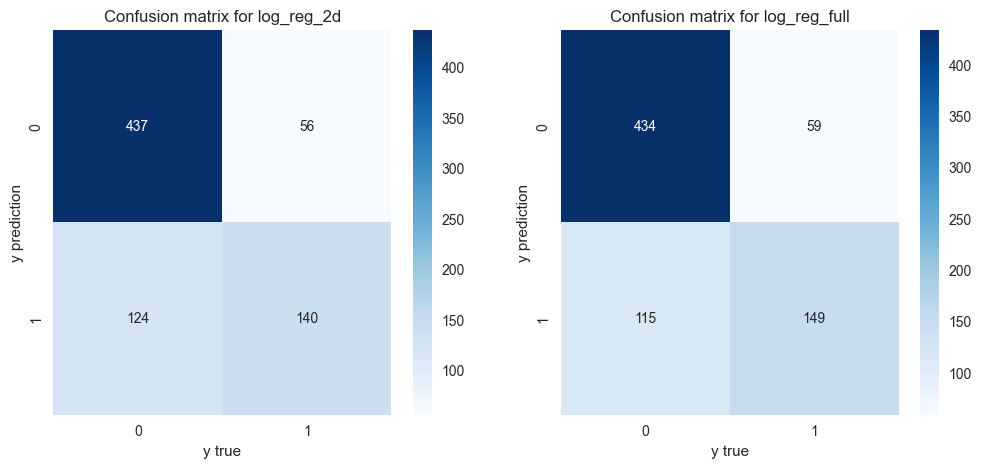

In [19]:
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y prediction')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y true')
axes[1].set_ylabel('y prediction');

Видно, что матрицы ошибок незначительно отличаются по своим составляющим. На их основе можно вручную вычислить остальные метрики для каждой из моделей, но мы воспользуемся встроенными функциями.

Расчёт метрик для модели `log_reg_2d`, обученной на двух факторах — Glucose и BMI:

In [20]:
#Модель log_reg_2d:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


Расчёт метрик для модели `log_reg_full`, обученной на всех доступных факторах:

In [21]:
#Модель log_reg_full:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


А теперь давайте сравним:

* Accuracy: доля правильных ответов для первой модели составляет 0.76, для второй — 0.77.
* Precision: способность первой модели отделять больных диабетом пациентов от здоровых пациентов составляет 0.71, а второй — 0.72.
* Recall: обобщающая способность находить больных пациентов среди всех пациентов для первой модели — 0.53, а для второй — 0.56.
* $F_1$: среднее гармоническое между precision и recall для первой модели составляет 0.61, а для второй — 0.63.

> Видно, что хоть и с небольшим отрывом, но вторая модель, обученная по всем признакам, превосходит первую модель по всем метрикам.

Для облегчения расчёта метрик можно использовать функцию `classification_report()` из модуля `metrics`. Она возвращает отчёт обо всех метриках классификации:

In [22]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



Что здесь отображено?

1. В первой части таблицы отображаются метрики precision, recall и f1-score, рассчитанные для каждого класса в отдельности. Столбец support — это количество объектов каждого из классов.
2. Во второй части таблицы отображена общая метрика accuracy. 
3. Далее идёт строка macro avg — это среднее значение метрики между классами 1 и 0. Например, значение в строке macro avg и столбце recall = (0.88 + 0.56)/2=0.72.
4. Завершает отчёт строка weighted avg — это средневзвешенное значение метрики между классами 1 и 0. Вес каждого класса определяется на основе доли объекта i-ого класса в выборке. Например, для случая двух классов метрика будет рассчитываться по формуле:

$$score_{weighted-avg} = \frac {n_{class_0}} {n} score_{class_0} + \frac {n_{class_1}} {n} score_{class_1}$$
где $n_{class_0}$ и $n_{class_1}$ — количество наблюдений класса 0 и 1 соответственно, $n$ — общее количество наблюдений в данных.

Ранее мы говорили о метриках precision, recall и $F_1$ только в контексте класса 1 (болеет диабетом). В отчёте `classification_report()` эти метрики рассчитаны и для класса 0. Смысл остаётся тем же, просто замените в рассуждениях класс 1 на класс 0.

Представим ситуацию, что дополнительная диагностика диабета в нашей клинике довольно дорогая. Но при этом нам важно выявить диабет у как можно большего числа людей. То есть нам важны и precision, и recall.

При этом наш recall равен 0.56, то есть мы находим только 56 % больных диабетом пациентов среди всех болеющих диабетом. Согласитесь, не очень хороший показатель (чуть выше половины). Можем ли мы его как-то улучшить?

Давайте будем изменять порог принятия решений. Сейчас порог составляет 0.5: то есть если вероятность наличия диабета у пациента выше 0.5, то модель относит его к больным диабетом, а если меньше 0.5 — к здоровым.

Но как будут меняться значения метрик recall, precision и $F_1$, если мы попробуем изменить порог вероятности, например на 0.4, 0.3 или 0.6? Давайте проследим за этим.

> **Примечание.** Геометрически регулировка порога вероятности для логистической регрессии означает движение разделяющей плоскости.

Сделаем предсказание вероятности наличия диабета моделью `log_reg_full` для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [23]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop('Outcome', axis=1))[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

Теперь у нас есть три списка (recall_scores, precision_scores и f1_scores), в которых хранятся значения метрик при различных значениях порога вероятности `p`.

Давайте построим графики зависимости метрик от порога вероятности:

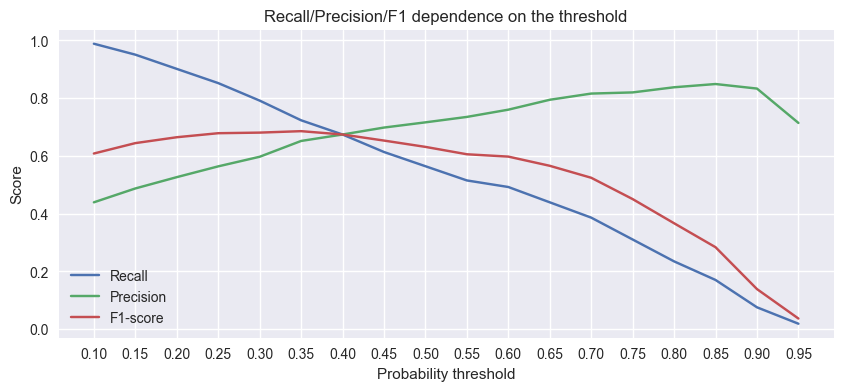

In [24]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Что мы видим на графике?

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение $F_1$-меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка `threshold=0.4`, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства $F_1$-меры.

Однако максимум $F_1$-меры достигается в другой точке — `threshold=0.35`. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что всё-таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при `threshold=0.4`.

Как теперь мы можем сделать предсказание класса, обладая данной информацией?

Мы делаем предсказание вероятности наличия диабета для всех пациентов, а затем вручную определяем всех пациентов, у которых эта вероятность > 0.4, в класс 1, а остальных — в класс 0. Далее считаем метрики:

In [26]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.4
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       493
           1       0.67      0.67      0.67       264

    accuracy                           0.77       757
   macro avg       0.75      0.75      0.75       757
weighted avg       0.77      0.77      0.77       757



Итак, мы смогли найти баланс между precision и recall, подобрав оптимальный порог вероятности.

Стоит отметить, что в DS-сообществе распространена практика подбора оптимального порога, так как он зависит от конкретных задач и значение 0.5 далеко не всегда является истинным.

### Задание 3.6
1 point possible (graded)
У вас есть истинные ответы y_true = [0, 0, 1, 1, 1, 1, 0, 1] и предсказанные ответы y_pred = [0, 1, 0, 0, 1, 1, 0, 1].

Вычислите значение метрики precision.

Ответ округлите до сотых.

In [27]:
y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]


In [28]:
metrics.precision_score(y_true, y_pred)

0.75

### Задание 3.7
1 point possible (graded)
У вас есть истинные ответы y_true = [0, 0, 1, 1, 1, 1, 0, 1] и предсказанные ответы y_pred = [0, 1, 0, 0, 1, 1, 0, 1].

Вычислите значение метрики recall.

Ответ округлите до сотых.

In [29]:
metrics.recall_score(y_true, y_pred)

0.6

### Задание 3.8
1 point possible (graded)
У вас есть истинные ответы y_true = [0, 0, 1, 1, 1, 1, 0, 1] и предсказанные ответы y_pred = [0, 1, 0, 0, 1, 1, 0, 1].

Вычислите значение метрики $F_{1}$.

Ответ округлите до сотых.

In [32]:
round(metrics.f1_score(y_true, y_pred), 2)

0.67